### Direction adjustment algorithm

In [ ]:
def deriv_adjust(train, pred, step = 3, print_ratio = False):
  '''
  pred assumed to immediately follow train for this method.
  '''
  n = len(train)
  num_samples = n // step
  m = len(pred)

  if n == 1 or max == 1:
    print("input too short or prediction too short for this function")
    raise ValueError
  
  start = n % step
  ind = start
  #print("start at", start)
  pred = pred.copy()
  
  while (num_samples < 2):
    step = step // 2
    num_samples = n // step
    start = n % step
    ind = start
    
  slopes = []
  for i in range(num_samples):
    half = step//2
    
    if ind-half < 0:
      here = 0
    else:
      here = ind-half
    #print(here)
    d_now  = np.mean(train[here:ind+half])
    d_next = np.mean(train[ind+half:ind+step+half])
    if np.isnan(d_now):
      print(f"error encountered for d_now, indicing from {ind-half} to {ind+half}")
      raise ValueError
    if np.isnan(d_next):
      print(f"error encountered for d_next, indicing {ind+half}{ind+2*half}")
    slopes.append((d_next - d_now)/ step)  
    ind += step
  
  ratio_change = []
  for i in range(len(slopes)-1):
    if slopes[i] == 0:
      ratio_change += [1]
      continue
    ratio_change += [slopes[i+1]/slopes[i]]
  
  weight = np.arange(len(ratio_change))
  weight = weight / np.sum(weight)
  ratio_change = np.array(ratio_change)

  if print_ratio:
    print(weight)
    print(ratio_change)

  ratio_change = np.sum(weight * ratio_change) #better weighting than avr.

  m = len(pred)
  num_changes = m // step
  
  # while (num_changes < 2):
  #   step = step // 2
  #   num_changes = m // step
  ind = 0

  pred_slopes = [slopes[-1]]
  d_reposit = [d_next]
  #corr_slopes = []

  # first derivative ratio correction
  #print(f"for every {step} data, we apply a correction")
  for i in range(num_changes): #+1 to handle the remainder ones at end
    d_now  = d_reposit[i]
    d_next = np.mean(pred[ind:ind+step]) 
    d_reposit.append(d_next) # for un-wasteful computation
    pred_slopes.append((d_next-d_now) / step)
    #print(f"actual slope: {pred_slopes[-1]} with ratio = {ratio_change}")
    corr_slope = ratio_change * pred_slopes[-1]
    #print(f"corr slope: {corr_slope} with step = {step}")
    correction = corr_slope * step - (d_next - d_now)
    print(correction, "on ", step, "data points")
    pred[ind:ind+step] += correction
    ind += step
  
  if len(pred_slopes) == 1:
    corr_slope = ratio_change * pred_slopes[0]
    correction = corr_slope * step - (d_next - d_now)
    
  pred[ind:] += correction
    #corr_slopes.append(corr_slope)
  
  # #2nd derivative correction
  # concavity_1 = []
  # for i in range(len(slopes)-1):
  #   concavity_1.append(slopes[i+1] - slopes[i])
  #   #print(concavity_1)
  # #print("slopes are ", slopes)
  
  # concavity_2 = []
  # for i in range((len(slopes)-2)):
  #   concavity_2.append((slopes[i+2] - slopes[i])/2)

  # concavity_1 = np.array(concavity_1)
  # concavity_2 = np.array(concavity_2)
  # std = np.std(concavity_1)
  # concavity_1 = concavity_1[abs(concavity_1 - np.mean(concavity_1) < 0.25 * std)]
  # std = np.std(concavity_2)
  # concavity_2 = concavity_2[abs(concavity_2 - np.mean(concavity_2) < 0.25 * std)]

  # concavity = (np.mean(concavity_1) + np.mean(concavity_2)) / 2
  
  # #apply correction
  # ind = 0
  # for i in range(len(pred_slopes)-1):
  #   correction = concavity - (pred_slopes[i+1] - pred_slopes[i])
  #   #print(f"expected slope = {concavity + pred_slopes[i]}, actual = {(pred_slopes[i+1])}, step size = {step}")
  #   correction = correction * step
  #   #print(correction)
  #   pred[ind:ind+step] += correction
  #   ind += step

  #adjust to connect with previous data (somewhat continuous data pattern observed)
  diff = abs(pred[0] - train[-1])
  if (diff > 0.005 * pred[0]) or diff > 50:
    print("gap bridging")
    correction = train[-1] - pred[0] 
    pred += correction 

  # adjust for patterns if any

  return pred

  

#### Motivation

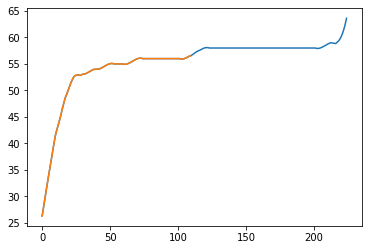

selected #115 of data, starting on day 137


In [ ]:
state = "Vermont"
feature = "Deaths"
degree = 3
alpha = .1
start = 0 # starting date for selecting data
window = 15
threshold = 0.00001
sample_train = train_by_state[state]
sample_test = testdf[testdf.Province_State == state]

value = sample_train[feature].values
value = savgol_filter(value.reshape(-1), window, degree)
combine = [[value[i]] for i in range(len(value))]
y = np.array([value[start:]]).reshape(-1, 1)
x = [[i + start] for i in range(len(y)-start)]

plt.plot(y)
selected_data = select_data(x, y, threshold)
if len(selected_data) < 15:
  threshold *= 10
  selected_data = select_data(x, y, threshold)
selected_data = np.array(selected_data).ravel()
plt.plot(y[:-len(selected_data)])
plt.show()
print(f"selected #{len(selected_data)} of data, starting on day {252-len(selected_data)}")

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


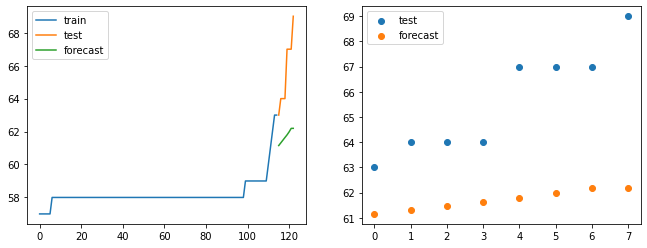

In [ ]:
basic_model = Prophet()
n = len(selected_data)
df = pd.DataFrame({'ds': sample_train.Date[-n:].to_list(), 'y' : selected_data})
#basic_model.fit(selected_data.reset_index() \
#              .rename(columns={'Date':'ds',
#                               'Deaths':'y'}))
m = len(sample_test)
basic_model.fit(df)
future = basic_model.make_future_dataframe(periods=len(sample_test))
forecast = basic_model.predict(future)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.arange(n), sample_train.iloc[-n:].Deaths.values, label = "train")
ax1.plot(np.arange(n,n+m), sample_test.Deaths.values, label = "test")
ax1.plot(np.arange(n,n+m), forecast.yhat.values[-m:], label = "forecast")
ax1.legend()

ax2.scatter(np.arange(m), sample_test.Deaths.values, label = "test")
ax2.scatter(np.arange(m), forecast.yhat.values[-m:], label = "forecast")
ax2.legend()

fig.set_size_inches(11, 4)
plt.show()

In [ ]:
MAPE(forecast.yhat.values[-m:], sample_test.Deaths.values), MAPE(new_pred, sample_test.Deaths.values)

(6.317342088496041, 1.3937093917354226)

-1.4061389218157982 on  3 data points
0.3954767258829548 on  3 data points
gap bridging


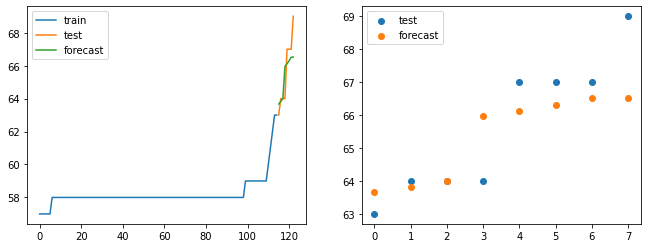

In [ ]:
s_selected_data = savgol_filter(selected_data.ravel(), window, degree)
new_pred = deriv_adjust(s_selected_data, forecast.yhat.values[-m:])
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.arange(n), sample_train.iloc[-n:].Deaths.values, label = "train")
ax1.plot(np.arange(n,n+m), sample_test.Deaths.values, label = "test")
ax1.plot(np.arange(n,n+m), new_pred, label = "forecast")
ax1.legend()

ax2.scatter(np.arange(m), sample_test.Deaths.values, label = "test")
ax2.scatter(np.arange(m), new_pred, label = "forecast")
ax2.legend()

fig.set_size_inches(11, 4)
plt.show()

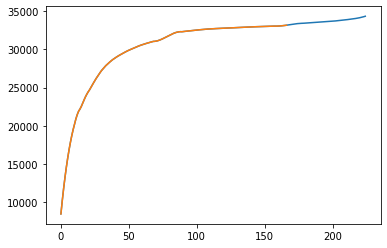

selected #58 of data, starting on day 84


In [ ]:
state = "New York"
feature = "Deaths"
degree = 3
alpha = .1
start = 0 # starting date for selecting data
window = 21
threshold = 0.00001
sample_train = train_by_state[state]
sample_test = testdf[testdf.Province_State == state]

value = sample_train[feature].values
value = savgol_filter(value.reshape(-1), window, degree)
combine = [[value[i]] for i in range(len(value))]
y = np.array([value[start:]]).reshape(-1, 1)
x = [[i + start] for i in range(len(y)-start)]

plt.plot(y)
selected_data = select_data(x, y, threshold)
selected_data = np.array(selected_data).ravel()
plt.plot(y[:-len(selected_data)])
plt.show()
print(f"selected #{len(selected_data)} of data, starting on day {142-len(selected_data)}")

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


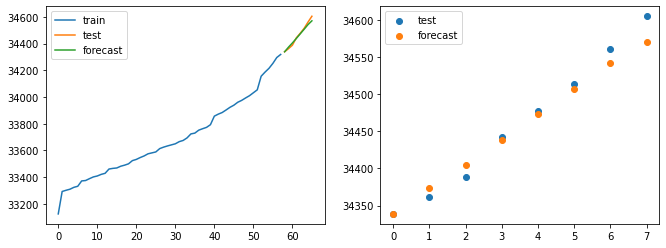

In [ ]:
basic_model = Prophet()
n = len(selected_data)
df = pd.DataFrame({'ds': sample_train.Date[-n:].to_list(), 'y' : selected_data})
#basic_model.fit(selected_data.reset_index() \
#              .rename(columns={'Date':'ds',
#                               'Deaths':'y'}))
m = len(sample_test)
basic_model.fit(df)
future = basic_model.make_future_dataframe(periods=len(sample_test))
forecast = basic_model.predict(future)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.arange(n), sample_train.iloc[-n:].Deaths.values, label = "train")
ax1.plot(np.arange(n,n+m), sample_test.Deaths.values[-m:], label = "test")
ax1.plot(np.arange(n,n+m), forecast.yhat.values[-m:], label = "forecast")
ax1.legend()

ax2.scatter(np.arange(m), sample_test.Deaths.values, label = "test")
ax2.scatter(np.arange(m), forecast.yhat.values[-m:], label = "forecast")
ax2.legend()

fig.set_size_inches(11, 4)
plt.show()

[0.         0.00653595 0.0130719  0.01960784 0.02614379 0.03267974
 0.03921569 0.04575163 0.05228758 0.05882353 0.06535948 0.07189542
 0.07843137 0.08496732 0.09150327 0.09803922 0.10457516 0.11111111]
[0.94388365 0.62633522 0.53099197 1.37306701 1.0158979  1.05794466
 0.93390944 1.04201616 0.96469253 1.22489481 1.24745045 1.16486666
 0.91587415 1.04837452 1.19408554 1.16937441 1.33514418 1.04058656]
5.926396551609855 on  3 data points
11.167537359026412 on  3 data points


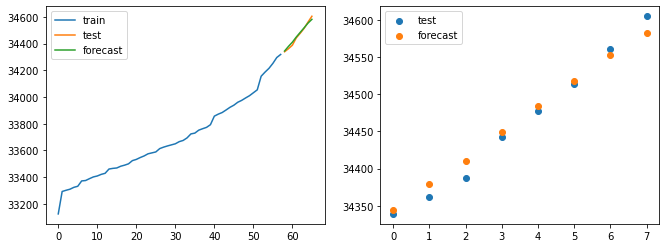

In [ ]:
new_pred = deriv_adjust(selected_data, forecast.yhat.values[-m:], print_ratio = True)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.arange(n), sample_train.iloc[-n:].Deaths.values, label = "train")
ax1.plot(np.arange(n,n+m), sample_test.Deaths.values[-m:], label = "test")
ax1.plot(np.arange(n,n+m), new_pred, label = "forecast")
ax1.legend()

ax2.scatter(np.arange(m), sample_test.Deaths.values, label = "test")
ax2.scatter(np.arange(m), new_pred, label = "forecast")
ax2.legend()

fig.set_size_inches(11, 4)
plt.show()